## Assignment 3: Clustering Models

In this assignment, you will implement the K-means method and apply it to image compression. Then you will use the Gaussian Mixture Models from the scikit-learn library and select the number of clusters K using the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC).

#### Part 1) Implement the K-means algorithm

In [68]:
import numpy as np
import pandas as pd
import random
import math
from collections import Counter
import sklearn.metrics as metrics

'''
Process of K-means:
    1. Select the desired amount of clusters, K.
    2. Randomly select K distinct data points; these are the initial clusters.
    3. Measure the distance between the first data point and all the K initial clusters. For 2D, euclidian distance.
    4. Assign the first point to its nearest cluster. Do the same thing for all the remaining points.
    5. Calculate the mean of each cluster.
    6. Then we repeat the process, but this time with the mean values as the clusters (cluster points).
    The result of the clusters produced by this method is measured by the variation within the clusters.
    The model cannot "see" the clusters, it can only determine weather the clusters are good or not with 
    measuring the variation within and then sum the variation. 
    Since the initial points are chosen at random, it is good practice to repeat the above method 
    multiple times, with different randomised initial point, and for each result
    measure the variation within each cluster and determine which one produced the best clusters 
    by comparing them with each other.  

    Pick K by finding the "elbow" in an "eblow-plot". The "elbow-plot" is a plot of the reduction
    in variance per value of K.

'''

# Sample n random distinct points from data x 
def sample_random_points(x, n):
    random_points = {}
    random_sample = random.sample(list(x), n)
    for i in range(n):
        random_points.update({i: random_sample[i]})

    return random_points

# Calculates the euclidean distance between two points p and q in 2D space
def euclid_distance(p, q):
    p1, p2, p3, p4 = p
    q1, q2, q3, q4 = q
    distance = math.sqrt((q1-p1)**2 + (q2-p2)**2 + (q3-p3)**2 + (q4-p4)**2)
    return distance

# Calculates the euclidean distance between a point and the given centroids
# Returns the index of the centroids which is closest to the point
def calc_distance_to_centroids(p, centroids):
    closest_centroid_index = -1
    min_distance = float('inf') # Initialised to max float value
    for i in range(len(centroids)):
        distance = euclid_distance(p, centroids[i])
        if distance <= min_distance:
            min_distance = distance
            closest_centroid_index = i
    return closest_centroid_index

def compute_mean_values(x, indices):
    groups = {} # {label: [data points]}
    # For every data point add it to the corresponding centroid index
    for i in range(len(x)):
        if indices[i] not in groups:
            groups.update({indices[i]: [x[i]]})
        else:
            groups[indices[i]].append(x[i])
    # Calculate the mean value for every data point for each index
    mean_values = {}
    for label in groups.keys():
        values = groups[label]
        mean = sum(values) / len(values) 
        mean_values.update({label: mean})
    return mean_values

# K-means without any aggregation and scoring (see below for and extended version)
def kmeans(x, K: int):   
    # x: input data     
    # K: number of centroids
    # centroids: contains the centers of the clusters
    # labels: contains the cluster index for each data point 

    tmp_centroids = sample_random_points(x, K)
    not_converged = True
    # Loop until convergence
    while not_converged:
        tmp_labels = []
        print('--------------- New iteration')
        for xn in x:
            cluster_index = calc_distance_to_centroids(xn, list(tmp_centroids.values()))
            tmp_labels.append(cluster_index)
        updated_centroids = compute_mean_values(x, tmp_labels) 

        # Check if the centroids have converged
        check = True
        while check:
            for i in range(len(tmp_centroids.values())):
                l = np.array(updated_centroids[i]) == np.array(tmp_centroids[i])
                if not l.all():
                    check = False 
                    # No convergence, updated the centroids
                    tmp_centroids = updated_centroids
                else:
                    centroids = tmp_centroids
                    labels = tmp_labels
                    not_converged = False
                    break

    return centroids, labels


In [69]:
# SSE and Siloutte scores

# Summation of all the distances from each point to its given cluster (centroid)
def sse(x, K, labels, centroids):
    sse_result = [0 for i in range(K)]
    for point, label in zip(x, labels):
        sse_result[label] += np.square(euclid_distance(point, centroids[label]))
    return sse_result

# Computes the distance from a given data point to all other data points
# within the same cluster
def within_cluster_distance(x, labels, cluster, data_point):
    cluster_length = 0
    acc_distance = 0
    a_i = 0

    for point, label in zip(x, labels):
        # Check if every coordinate in the data point is equal to the other,
        # i.e. if it's the same data point
        l = np.array(data_point) == np.array(point)
        if (not l.all()) and label == cluster:
            acc_distance += euclid_distance(data_point, point)
            cluster_length += 1
    
    a_i = (1 / (cluster_length- 1)) * acc_distance
    return a_i

# Computes the distance from a given data point to all other data points
# outside of its cluster
def between_cluster_distance(x, labels, K, cluster, data_point):
    # Was K-1 before, but the cluster "within" can be in the middle,
    # thus all indices are needed. But in this case one will be null
    other_clusters = [0 for i in range(K)] 
    cluster_lengths = [0 for i in range(K)]

    for point, label in zip(x, labels):
        if label != cluster:
            other_clusters[label] += euclid_distance(data_point, point)
            cluster_lengths[label] += 1
    
    for c_k in range(len(other_clusters)):
        if c_k != cluster:
            other_clusters[c_k] = (1/cluster_lengths[c_k]) * other_clusters[c_k]
    
    # Return the min, of all clusters except the one of focus, i.e. all the others
    other_clusters.pop(cluster)
    return min(other_clusters)


# A mixture of distance between points within the cluster and distance between points from
# the other clusters, i.e. outside of the given points cluster.
def siloutte_score(x, K, labels):
    score = 0
    for point, label in zip(x, labels):
        a_i = within_cluster_distance(x, labels, label, point) 
        b_i = between_cluster_distance(x, labels, K, label, point)
        score += ((b_i - a_i)/np.max([b_i, a_i]))
    return score/float(len(x))

""" def elbow_graph(features, stop, labels, centroids):
    ax, fig = plt.subplot() """

' def elbow_graph(features, stop, labels, centroids):\n    ax, fig = plt.subplot() '

In [88]:
# Kmean using SSE to evaluate each iteration for the same K and return the on with lowest SSE-score
def kmeans_plus(x, K: int, n_iter: int):
    # x: input data     
    # K: number of centroids
    # n_init: the number of initial guesses for the centroids
    # centroids: contains the centers of the clusters
    # labels: contains the cluster index for each data point 

    all_centroids = []
    all_labels = []
    all_siloutte_scores = []
    for _ in range(n_iter):
        centroids, labels = kmeans(x, K)
        all_centroids.append(centroids)
        all_labels.append(labels)
        all_siloutte_scores.append(siloutte_score(x, K, labels))
    
    best_score_index = all_siloutte_scores.index(max(all_siloutte_scores))
    return all_centroids[best_score_index], all_labels[best_score_index]

    

In [90]:
# Testing the algorithm
from sklearn.datasets import make_blobs
features, true_labels = make_blobs(
    n_samples = 200,
    n_features=4,
    centers = 3,
    cluster_std= 3,
    random_state= 3
)

centroids, labels = kmeans_plus(features, 3, 5)
print('Centroids:', centroids)
trues = 0
falses = 0
for label, true_label in zip(labels, true_labels):
    if label == true_label:
        trues += 1
    else:
        falses += 1
print('Correctly clustered data points:', trues)
print('Incorrectly clustered data points:', falses)

print('SSE: ', sse(features, 3, labels, centroids))
# Seems to checkout
sil_score = siloutte_score(features, 3, labels)
print('Siloutte score:', sil_score)
s_score = metrics.silhouette_score(features, labels)
print(s_score)

--------------- New iteration
--------------- New iteration
--------------- New iteration
--------------- New iteration
--------------- New iteration
Centroids: {0: array([ 1.5477881 ,  4.47538741, -3.96027111,  0.76067143]), 2: array([-9.02296591, -0.37486566, -9.61959273, -0.82826058]), 1: array([ 8.09223496,  8.04471817, -7.81801969, -6.39867406])}
Correctly clustered data points: 190
Incorrectly clustered data points: 10
SSE:  [2437.9278982551086, 2259.7575882479714, 2708.3255169939507]
Siloutte score: 0.3694674384166092
0.3789576767719673


* **If you run this algorithm multiple times, do you get the same result every time? If so, why; if not, how do you determine which result is the best one?**
    
    The result isn't the same, since the algorithm involves randomness. 
    The K initial points, centroids for the K clusters, are chosen at random. Thus, each iteration of the algorithm
    could result in different results, and more often than not do.
    

* **How do you choose what K value to use?**

    A good metric to determine what K value to use is the SSE-score. But one cannot blindly use it, since we want the SSE-score to be low, but not as low as possible, since SSE -> 0 when K = N, meaning that each data point has its own cluster. This defeats the purpose of clustering in the first part. Thus, one want to choose K at the elbow-point of the SSE-score for different values of K. This is essentially the point of maximum curvature, i.e. the largest K where the SSE-score doesn't decrease significantly by further increasing K. This K kan be found by plotting the SSE-score, resulting in a so called elbow-graph. An example of an elbow-graph can be seen later on in the notebook.
    
    Another helpfull measuring method is the Siloutte score of the K-means algorithm. The siloutte score measures how well each data point has been clustered in relation to the cluster it belongs to and the other clusters. Essentially how well defined each cluster is. For a given data point it outputs a value between -1 and 1. With a high value indicating an assignment to a well defined cluster and a low value to an overlapping or poorly defined cluster. The final score is the sum of all the scores for each individual data point from every cluster.

* **Implement both SSE and the Silhouette score; use them to address these questions.**

    See code cell above.


* **Discuss the similarities and differences between 1) K-means, 2) Gaussian Mixture Models (GMM) and 3) the Gaussian naive Bayes classifier in terms of their assumptions and parameter estimation methods. In particular, write down the implications of each assumption (e.g., x and y are assumed to be independent, and therefore, we have ....).  You can choose to write your answers as Python code, pseudo code or mathematical equations.**

    K-means and GMM are clustering models, while the Gaussian naive Bayes classifier is a classification model. 

    In the K-means algorithm the clusters are assume to be of a spherical shape, given this assumption, it doesn't perform well on clusters that take on distinctively different shapes. Another assumption is the number of clusters. One has to decide the K before running the algorithm. However, one can work around this assumption by running several iterations of the algorithm, with different K-values and then determine the best one with SSE and an elbow-graph.
    The parameter estimation in K-means is rather straight forward; it's an iterative method, that updated the centroids until convergence, from the initial centroids that are K points chosen at random.

    In GMM and Gaussian naive Bayes we assume that the data follows a Gaussian (normal) distribution. Also, we assume that the likelihood of observing one sample is independent from all other samples, such that we can multiple the likelihoods with each other. But GMM differs from Gaussian naive Bayes in that it doesn't necessarily assume independence for data from different dimension, where Gaussian naive Bayes does. GMM also assumes the value of K.

    GMM estimates its parameters using the Expectation-Maximization algorithm, which is an iterative method that in essence can be devided in to, expectation: computing the posterior probability of the cluster for each data point, and maximisation: maximise the expected (log) likelihood found on the expectation-step, for each cluster. These steps are repeated until the stopping criteria is met, which either be a check if a chosen objective function have not changing or any of the parameters, from the last iteration.

    The Gaussian naive Bayes estimates the parameters by calculating the mean-value and variance for each class, in order to being able to use the PDF for a Gaussian distribution, for which the model assumes the data is distributed from.


    Takeaways: While K-means is a more simple algorithm than GMM, using only distance based estimation, GMM can be viewed as a more sophisticated version of K-means. GMM uses soft clustering in comparison to K-means, which gives more nuance to the clustering 
    If one knows that the data doesn't follow a Gaussian distibution, GMM and Gaussian Naive Bayes isn't a particularily good model, since the assumption is then plain and simply wrong.
    The assumption that the data is independent is a strong one, and more often than not it isn't the case. But even so it can lead to satisfying results and the main point of the assumption is how it makes the models much more simple.

    

#### Part 2) Apply the K-means algorithm to compress images

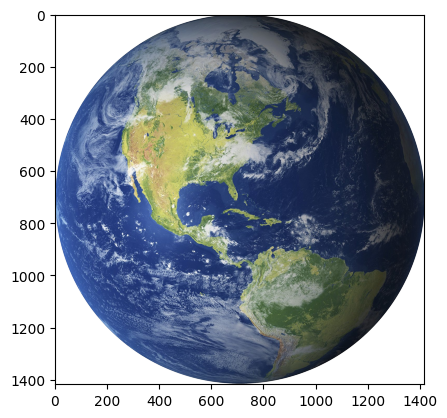

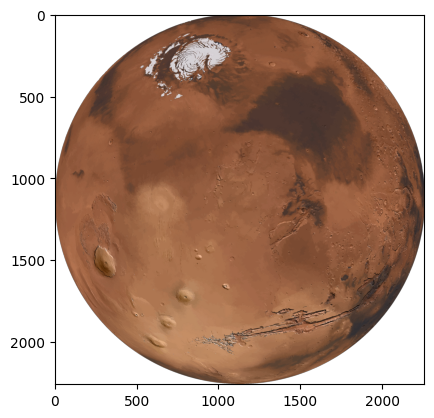

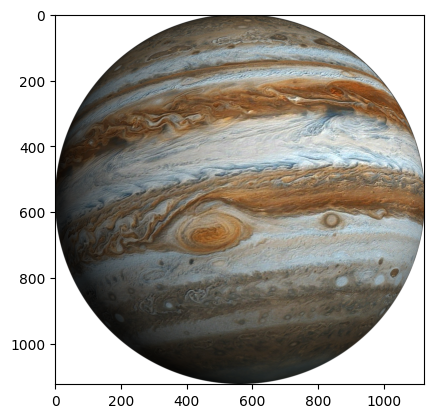

In [54]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

def process_images():
    # Reading and scaling
    earth = mpimg.imread('earth.png') #.astype(np.float32) # / 255
    mars = mpimg.imread('mars.png') 
    jupiter = mpimg.imread('jupiter.png') 

    images = np.array([earth, mars, jupiter], dtype='object')
    # Reshaping the images

    
    return images

images = process_images()
for i in range(len(images)):
    fig, ax = plt.subplots()
    ax.imshow(images[i])


In [55]:
def compress_images(images, K):
    original_images = images
    compressed_images = []
    processed_images = []
    # Reshaping the images
    for i in range(len(images)):
        images[i] = np.reshape(images[i], 
            (images[i].shape[0] * images[i].shape[1], images[i].shape[2]))

    for image in images:
        print(type(image))
        print(image.shape)
        compressed_images.append(kmeans(image, K, 1))
    
    # Restoring the images to its original shape
    for i in range(len(compressed_images)):
        centroid, labels = compressed_images[i]
        og_image = original_images[i]
        centroid = np.array(centroid)
        recovered = centroid[labels, :]
        processed_images.append(
            np.reshape(
                recovered, 
                (
                og_image.shape[0], 
                og_image.shape[1],
                og_image.shape[2]
                )), 
            )

    return process_images 

compressed_images = compress_images(images, 3)

    

for i in range(len(compressed_images)):
    fig, axes = plt.subplots(len(compressed_images))
    axes[i].imshow(compressed_images[i])

<class 'numpy.ndarray'>
(2010724, 4)
--------------- New iteration
{2: array([0.95058243, 0.95754763, 0.95719834, 0.18460775]), 1: array([0.69544262, 0.70736837, 0.4854527 , 0.9992338 ]), 0: array([0.22762908, 0.28927081, 0.39039711, 0.99927167])}
Is this reached?
<class 'numpy.ndarray'>
(5107600, 4)
--------------- New iteration


KeyError: 0

#### Part 3) Use AIC and BIC to choose K for Gaussian Mixture Models 

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.mixture import GaussianMixture
data = load_breast_cancer().data 
n_components = [i for i in range(1, 20)]
gmm = GaussianMixture(n_components=3)
models = [GaussianMixture(n_components=n).fit(data) for n in n_components]


# Akakie information criterion for the given model and data
def aic(model, data):
    log_likelihood = model.score(data) * data.shape[0]
    n_parameters = model._n_parameters()
    score = -2 * log_likelihood + 2 * n_parameters
    return score

# Bayesian information criterion for the given model and data
def bic(model, data):
    log_likelihood = model.score(data) * data.shape[0]
    n_parameters = model._n_parameters()
    score = -2 * log_likelihood + np.log(data.shape[0]) * n_parameters
    return score


Text(0.5, 0, 'number of components')

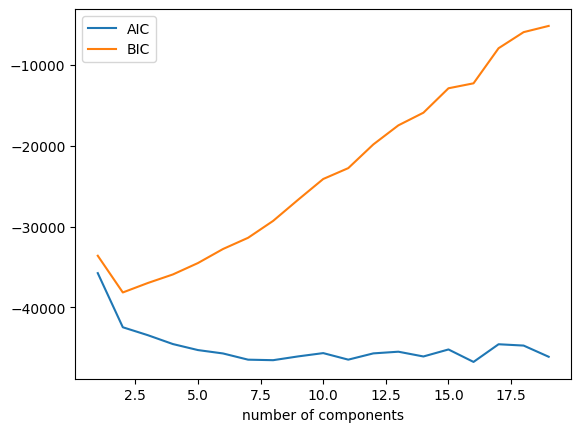

In [40]:
# Plotting the results
fig, ax = plt.subplots()
ax.plot(n_components, [aic(model, data) for model in models], label='AIC')
ax.plot(n_components, [bic(model, data) for model in models], label='BIC')
ax.legend(loc='best')
ax.set_xlabel('number of components')

**Discussion**
We want to find the K that balances that as the lowest "error", while simultaineously staying true to Occam's razor, i.e a preferance for as simple models as possible.
This is exactly what AIC and BIC measures, but following the same principle as described before, with k-means and choosing K, we don't want the K (or number of mixture components) to be unreasonably high, since it defeats the purpose of clustering when K is too high. So, we want to find the balance point between the lowest error and simplest model. 
As show by the plot, we can see that this point is at K = 2.
The GMM prediction at K = 2 can is shown at the plot below.

(569, 30)


Text(0.5, 1.0, 'Clustered data using GMM with K = 2')

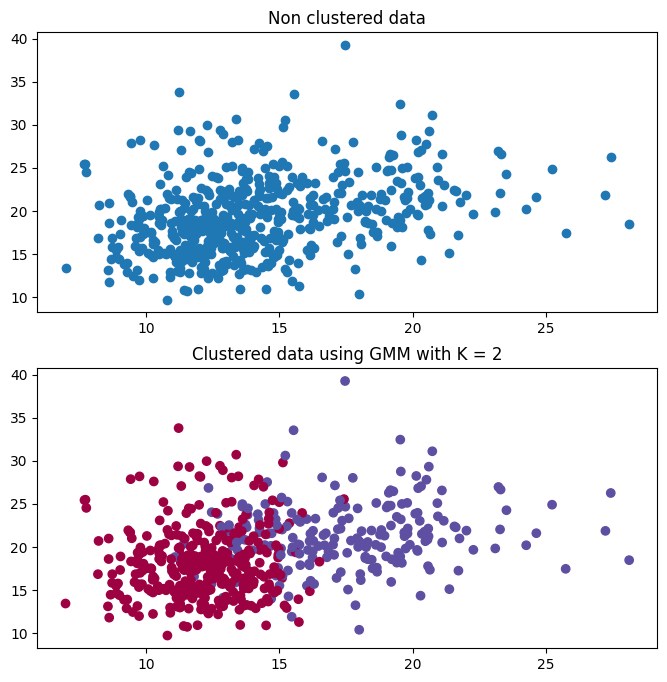

In [53]:
gmm = GaussianMixture(n_components=2)
gmm.fit(data)
labels = gmm.predict(data)
print(data.shape)
fig, axes = plt.subplots(2, figsize=(8,8))
axes[0].scatter(data[:, 0], data[:, 1])
axes[0].set_title('Non clustered data')
axes[1].scatter(data[:, 0], data[:, 1], c=labels, cmap='Spectral')
axes[1].set_title('Clustered data using GMM with K = 2')